## Explorations of biases from overlapping signals with coincident coalescences

Here we explore the biases arising from an overlapping signal with coincident coalescence, namely with difference between coalescence times smaller than a fraction of a second.

In [1]:
# Import packages that you may already have pip installed in your environment.

import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings

# Import other packages which are less common and specific to the task at hand.

import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)

### Useful functions

In [2]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = 10**6 * pc

Here we define the TaylorF2 approximant up to 3.5PN contributions.
References for TaylorF2 models

- https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)]
- https://arxiv.org/pdf/0907.0700.pdf [Eqs.(3.17)-(3.18)]

In [3]:
def htilde(f,Deff, params,t0,phi0,tune):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Important:
    
    This model is defined in the frequency domain directly and it necessitates
    continuous fourier transforms in the inner products (no discretizations!)
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 

    
    Note on 'tune':
    
    This is a tuning parameter. If tune=1, then we have the 3.5PN waveform.
    If tune is not 1, then we introduce a systematic error into the model.
    
    """
    # Units
    
    GM_sun = 1.3271244*1e20
    c =2.9979246*1e8
    M_sun =1.9884099*1e30
    G = 6.6743*1e-11
    pc= 3.0856776*1e16
    pi = np.pi
    Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp = np.exp(params[0])
    eta = params[1]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    
    # PN expansion parameter (velocity).
    v = (pi*G*Mchirp*eta**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756+55/9*eta)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi2PN = (15293365/508032+27145/504*eta+3085/72*eta**2)*v**(-1)
    psi25PNlog = pi*(38645/252- 65/3 *eta)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 -640/3 * pi**2 -6848/21 *np.euler_gamma
              + eta*(-15335597827/3048192+2255/12 * pi**2-1760/3 * theta - 12320/9 * delta)
              + eta**2 *76055/1728 - eta**3 * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + 378515./1512 *eta - 74045./756 * eta**2* tune)

    psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN_tails+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    
    return amplitude* np.exp(-1j*psi)

Define the chirping time for Schwarzchild spacetimes, which will determine the observation time of the source (even if we may want t consider spinning systems..)

$$T_\text{chirp}:=T_{\text{obs}}=\frac{5}{256\eta}\left(\frac{c^3}{G M}\right)^{5/3} (\pi f_0)^{-8/3}\left[1+\mathcal{O}(f_0^{2/3})\right]$$

In [4]:
def T_chirp(fmin,M_chirp,eta):
    
    """
    Function to give time at chirp from an initial frequency. 
    Used to pick out the total observation time. 
    """
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

We define the inner product between signals here. Notice that this function takes as input the continuous Fourier-domain waveforms.

In [5]:
def inner_prod(sig1_f,sig2_f,PSD,delta_f):

    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

### Generate toy signals in the time and frequency domains

Here we need to input the parameters of the reference signal and the overlapping signal.

In [6]:
"""
Signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =0.0
phi0 =np.pi/3

# variables to sample through

Deff_true = 5*10**3 *Mpc
logDeff_true = np.log(Deff_true)

m1_rescale = 21 # in solar masses
m2_rescale =  15 # in solar masses
mtot_rescale = m1_rescale+m2_rescale # in solar masses
eta_true = m1_rescale* m2_rescale/mtot_rescale**2 #dimensionless
Mchirp_rescale = mtot_rescale * eta_true**(3/5) # in solar masses
Mchirp_true = Mchirp_rescale* M_sun
logMchirp_true = np.log(Mchirp_true)

pars = [logMchirp_true,eta_true] # array of parameters for waveform.

"""
Overlapping signal #1:

Here we define a function of the coalescence time for the overlapping signal. 

"""


def h_overlap(tov1):

    # Fix these two impostors, assume they are known perfectly.

    phiov1 =0.0

    # Find a resonable distance for the signal 

    Deff_ov1 = 1*10**4 *Mpc
    logDeff_ov1 = np.log(Deff_ov1)

    m1_rescale =  25 # in solar masses
    m2_rescale =  20 # in solar masses
    mtot_rescale = m1_rescale+m2_rescale # in solar masses
    eta_ov1 = m1_rescale* m2_rescale/mtot_rescale**2 #dimensionless
    Mchirp_ov1 = mtot_rescale*(eta_ov1)**(3/5)
    Mchirp_ov1 =Mchirp_ov1* M_sun
    logMchirp_ov1 = np.log(Mchirp_ov1)

    pars_ov1 = [logMchirp_ov1,eta_ov1] # array of parameters to sample through
    
    return htilde(freq,Deff_ov1,pars_ov1,tov1,phiov1,tune_GR), pars_ov1, [Deff_ov1,phiov1]

Here we set up the signal in the time and frequency domain.

In [7]:
"""
Frequency domain
"""
fmin = 10
fmax = c**3 * (6*np.sqrt(6)*GM_sun*mtot_rescale*np.pi)**-1 # ISCO of Schw. in circ. orb.

Tobs = T_chirp(fmin,Mchirp_true,eta_true)


delta_t =1/(2*fmax) # Sampling interval
t = np.arange(0,Tobs,delta_t)   # Form time vector from t0 = 0 to tn = tmax 
n_t = int(2**np.ceil(np.log2(len(t))))

delta_f = 1/Tobs
freq = np.arange(fmin,fmax,delta_f)
print('df:', delta_f)
print('fmax:', fmax)
print('Length of frequency array:', len(freq))

df: 0.0681553008334638
fmax: 122.14374579558837
Length of frequency array: 1646


### Build up detector noise

Next, we build up noise. We use Parseval's theorem to calculate the noise. This amounts to using the following variance

$$
\sigma^2_n= \frac{S_n}{4 dt} N_t
$$

where:

- $\sigma^2$ is the noise variance.
- $S_n$ is the detector's PSD.
- $dt$ is the sampling interval.
- $N_t$ is the length of the (padded) signal.

In [8]:
def ET_PSD(f):
    """
    Analytical fit: https://arxiv.org/pdf/1201.3563.pdf
    """
    x = f/100

    hn_sqr = (2.39 * 1e-27 * x**(-15.64) 
              + 0.349 * x**(-2.145) 
              + 1.76 * x**-0.12 
              + 0.409 * x**(1.10))**2
    
    return 1e-50 * hn_sqr

In [9]:
# Noise generation

PSD = ET_PSD(freq)

noisevar = PSD/(4*delta_f)                   # Parseval's theorem
noisemean = 0. 

noise_real = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute real noise.
noise_imag = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute imaginary noise.

n_f = np.array(noise_real + 1j*noise_imag)         # noise array in the frequency domain.

### Generate data array

In [10]:
# signals

tune_GR = 1. #we tune the parameter in the waveform to have no systematic errors.

"""
Notice that we input in the data perfectly known waveforms.
Furhter notice that we pick a specific tau (-0.2). Change it as you please in h_ov1_f. 
"""

h_true_vec_f = htilde(freq,Deff_true,pars,t0,phi0,tune_GR)
h_ov1_f = h_overlap(-0.2)[0] # notice choice of tau here! A posteriori, this is what gives the largest bias.
data_f_vec = (  h_true_vec_f #reference signal
              + h_ov1_f      #one overlapping signal
             )

Check the SNR of all the sources to infer.

In [11]:
def inner_prod(sig1_f,sig2_f,PSD,delta_f):

    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

In [12]:
# SNR of the resolved source and of the unfitted overlapping signal.

h_SNR2 = inner_prod(h_true_vec_f,h_true_vec_f,PSD,delta_f)  #CTFT
h_ov_1 = inner_prod(h_ov1_f, h_ov1_f,PSD,delta_f)

print('Optimal SNR for the resolved source is',np.sqrt(h_SNR2))
print('Optimal SNR for the overlapping source(s)',np.sqrt(h_ov_1))

Optimal SNR for the resolved source is 75.49108711661539
Optimal SNR for the overlapping source(s) 45.818803113752466


We can check another metric for the overlap through the overlap function

$$
\mathcal{O}(h_1,h_2) = \frac{(h_1|h_2)}{\sqrt{(h_1|h_1)(h_2|h_2)}}
$$

In [13]:
# Overlap of signals


def Overlap(sig1_f,sig2_f,PSD,delta_f):
    numerator = inner_prod(sig1_f,sig2_f,PSD,delta_f)
    denominator = np.sqrt(inner_prod(sig1_f,sig1_f,PSD,delta_f) \
                          * inner_prod(sig2_f,sig2_f,PSD,delta_f))
    return numerator/denominator


"""
Notice that the overlap function is not necessarily high. 
Biases will still be obtained if the difference in coalescence times is small.
"""
print('Overlap ref and #1:',Overlap(h_true_vec_f,h_ov1_f,PSD,delta_f))

Overlap ref and #1: -0.019915261339484305


Finally we plot the time domain waveforms

In [14]:
# Nice plotting options for corner plots.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":11
})

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = True

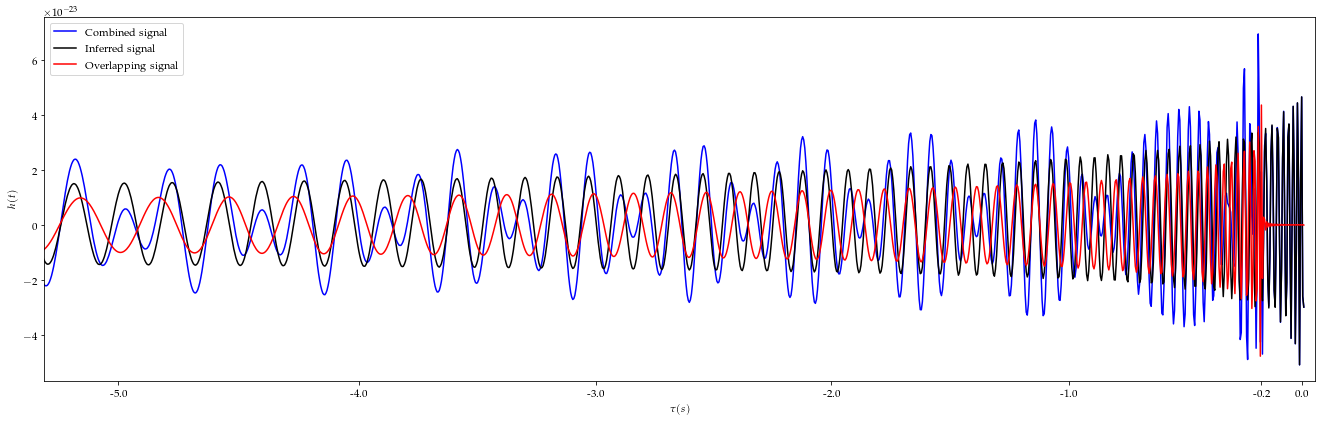

In [15]:
# Choose initial time for the TD plot.

t_initial = 2000


# Find ticks as a function of tau = t_c - x s

T_ticks = []
T_range = [-5.0,-4.0,-3.0,-2.0,-1.0,-0.2, 0.0]

for t in T_range:
    
    hf = np.fft.irfft(h_overlap(t)[0]/delta_t)[t_initial:]
    hf_max = max(hf)
    T_ticks.append(np.where(hf==hf_max)[0][0])


plt.plot(np.fft.irfft(h_ov1_f/delta_t)[t_initial:]+np.fft.irfft(h_true_vec_f/delta_t)[t_initial:], 
         color='blue',label='Combined signal')
plt.plot(np.fft.irfft(h_true_vec_f/delta_t)[t_initial:], color='black',label='Inferred signal')
plt.plot(np.fft.irfft(h_ov1_f/delta_t)[t_initial:], color='red',label='Overlapping signal')
plt.ylabel(r'$h(t)$')
plt.xlabel(r'$\tau (s)$')
labels = [str(i) for i in T_range]
plt.xticks(T_ticks,labels=labels)
plt.xlim([100,1300])
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.tight_layout()
#plt.savefig('TD_waveform.pdf',dpi=200)
plt.show()

### Setting up the MCMC

Here we setup the MCMC check. First of all we write down the priors.

In [16]:
# Priors on frequency
eta_low_range = -10
eta_high_range = 10

# Priors on the phase
logMchirp_low_range = np.log(1*M_sun)
logMchirp_high_range = np.log(200000*M_sun)

In [17]:
def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range. Eta is the problem')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range. M is the problem')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

Next we calculate the (log-)likelihood.
$$
p(d|\theta)\sim \exp\left\{\frac{1}{2}\left(d-h|d-h\right)\right\}
$$
and the log posterior.

In [18]:
def llike(params, data_f):
    
    logMchirp1 = params[0]
    eta1 = params[1]
    
    """
    Notice that we input our waveform templates (without systematic
    errors) in the PE. Since the data contains the true waveforms, 
    we do not expect biases to arise from waveform errors.
    """
    
    signal_f = htilde(freq,Deff_true,[logMchirp1,eta1],t0,phi0,tune_GR)
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    '''
    data_f = data_f_vec
    
    res = (llike(params, data_f) 
           # Prior reference signal
           + lprior_logMchirp(params[0]) 
           + lprior_eta(params[1])
          )

    return res

In [19]:
iterations = 10000
pos = [logMchirp_true,eta_true]


"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""
start= pos*(1+1e-9* np.random.randn(2*len(pos), len(pos)))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [00:22<00:00, 446.72it/s]


In [20]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

# Stack all of the parameters of the posterior.
org_samp = np.vstack((flat_samples[:,:,0].flatten() , flat_samples[:,:,1].flatten())).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (34000, 2)
median =  [72.47886033  0.23526239]


In [21]:
CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=18), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=16), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=2, # set a limit to ticks in the x-y axes.
    title_fmt=".6f", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

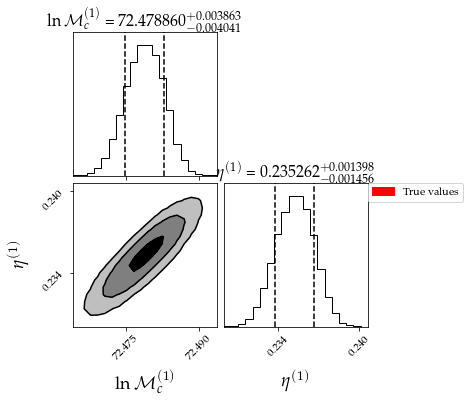

In [22]:
labels = [r'$\ln\mathcal{M}^{(1)}_c$', r'$\eta^{(1)}$']

truths=[logMchirp_true,eta_true]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(1.0,1.0), 
           loc='upper left', borderaxespad=0.)
plt.show()

### Fisher matrix predictions

We calculate the waveform derivatives that will enter the Fisher matrix with the finite difference method, 

$$ \frac{\partial h_m(f;\Theta^i)}{\partial \Theta^i} \approx \frac{h_m(f;\Theta^i+ \delta\Theta^i)-h_m(f;\Theta^i -\delta\Theta^i)}{2 \delta\Theta^i} $$

where $\Theta=\{\log \mathcal{M}_c,\eta\}$

In [23]:
"""
Derivatives of reference signal.
"""

# Derivative wrt Mc.

lnMc_delta = 1e-4
pars_p = [pars[0] + lnMc_delta,pars[1]]
pars_m = [pars[0] - lnMc_delta,pars[1]]
d_dlnMc_ref = (htilde(freq,Deff_true,pars_p,t0,phi0,tune_GR)
           -htilde(freq,Deff_true,pars_m,t0,phi0,tune_GR))/(2*lnMc_delta)

# Derivative wrt eta.
eta_delta = 1e-6
pars_p = [pars[0],pars[1] + eta_delta]
pars_m = [pars[0],pars[1] - eta_delta]
d_deta_ref = (htilde(freq,Deff_true,pars_p,t0,phi0,tune_GR)
          -htilde(freq,Deff_true,pars_m,t0,phi0,tune_GR))/(2*eta_delta)

Build up the Fisher matrix

In [24]:
Ntot = 1 # total number of sources to sample through.

diff_vec =[d_dlnMc_ref, d_deta_ref]

fish_mix = np.eye(2*Ntot)
for i in range(0,2*Ntot):
    for j in range(0,2*Ntot):
        fish_mix[i,j] = inner_prod(diff_vec[i],diff_vec[j],PSD,delta_f)

In [25]:
# Does the Fisher matrix approximate well (within a few digits) the MCMC widths? 
# If not, then there is a problem.

print('FM width predictions:',np.sqrt(np.diag(np.linalg.inv(fish_mix))))
print('MC width predictions:',  [np.round(np.sqrt(np.var(flat_samples[:,:,i])),17) 
                                 for i in range(0,2*Ntot)])

FM width predictions: [0.00375711 0.00139898]
MC width predictions: [0.00389197555925904, 0.00140799213438017]


Calculate biases from noise using

$$\Delta\Theta^i_{\text{noise}} =\Gamma^{ij}b_j$$

where the bias vector in this case where biases come from noise is

$$b_j = \left(\frac{\partial h}{\partial \Theta^j}\bigg|\,h^{(2)}\right)$$

In [26]:
# Inverse of the full fisher matrix

print('(disgusting) condition number for the full FM: ',np.linalg.cond(fish_mix))
FM_inv = np.linalg.inv(fish_mix)

# bias vector 

"""
Add confusion noise here.
"""
deltah = h_ov1_f

b = [inner_prod(i,deltah,PSD,delta_f) for i in diff_vec]

# Inference biases

biases = np.matmul(FM_inv,b)

(disgusting) condition number for the full FM:  13916.716313219116


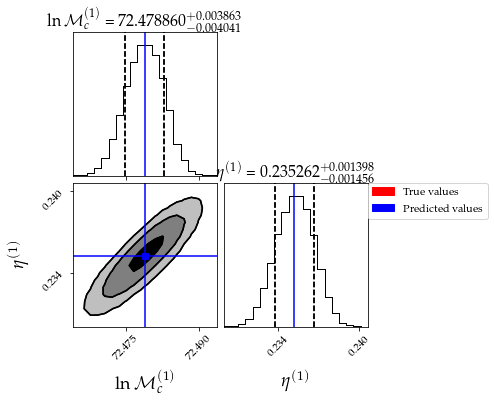

In [27]:
truths_bias =[logMchirp_true + biases[0], eta_true + biases[1 ]]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)
fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths_bias,
                    truth_color='blue', 
                    color='black',**CORNER_KWARGS, fig=fig)

red_patch = mpatches.Patch(color='red', label='True values')
blue_patch = mpatches.Patch(color='blue', label='Predicted values')
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(1.0,1.0), 
           loc='upper left', borderaxespad=0.)
#plt.savefig('MCMC_check_Jonlie.pdf')
plt.show()

### Fisher explorations

In this section of the code we study what happens when we vary the time of coalescence of the overlapping signal.

- First we build an array of bias ratios $R(\theta) = |\Delta \theta_\text{conf}/\Delta \theta_\text{stat}|$. Recall that if this guy is >1, then we expect significant bias (see discussion in the paper). We build this like in the bias prediction calculation used to check the Fisher matrix. We do vary tau in the argument of the overlapping signal.

In [28]:
delta_theta = np.sqrt(np.diag(np.linalg.inv(fish_mix)))

R_Mc_list = []
R_eta_list = []
tau_list = [x / 100.0 for x in range(-200, 200, 10)]

for tau in tau_list:

    deltah_temp = h_overlap(tau)[0]

    b_temp = [inner_prod(i,deltah_temp,PSD,delta_f) for i in diff_vec]

    # Inference biases

    biases_temp = np.matmul(FM_inv,b_temp)
    R_Mc_list.append(np.abs(biases_temp[0]/delta_theta[0]))
    R_eta_list.append(np.abs(biases_temp[1]/delta_theta[1]))

Build up Pearson correlation coefficients. And plot them as a function of $\tau$ as well.

In [29]:
def Pearson_coeff(Cov,a,b):
    return Cov[a][b]/np.sqrt(Cov[a][a]*Cov[b][b])

In [30]:
"""
Derivatives of overlapping signal #1.
"""
sigma_Mc1_Mc2_list   = []
sigma_eta1_eta2_list = []
sigma_Mc1_eta2_list  = []
sigma_Mc2_eta1_list  = []
Cov_joint_list = []

for taau in tau_list:

    pars_ov1 = h_overlap(taau)[1]
    Deff_ov1 = h_overlap(taau)[2][0]
    phiov1   = h_overlap(taau)[2][1]

    # Derivative wrt Mc.

    lnMc_delta = 1e-6
    pars_p = [pars_ov1[0] + lnMc_delta,pars_ov1[1]]
    pars_m = [pars_ov1[0] - lnMc_delta,pars_ov1[1]]
    d_dlnMc_ov1 = (htilde(freq,Deff_ov1,pars_p,taau,phiov1,tune_GR)
               -htilde(freq,Deff_ov1,pars_m,taau,phiov1,tune_GR))/(2*lnMc_delta)

    # Derivative wrt eta.
    eta_delta = 1e-8
    pars_p = [pars_ov1[0],pars_ov1[1] + eta_delta]
    pars_m = [pars_ov1[0],pars_ov1[1] - eta_delta]
    d_deta_ov1 = (htilde(freq,Deff_ov1,pars_p,taau,phiov1,tune_GR)
              -htilde(freq,Deff_ov1,pars_m,taau,phiov1,tune_GR))/(2*eta_delta)
    # Build joint Fisher matrix

    Ntot = 2 # total number of sources to sample through.

    diff_vec_joint =[d_dlnMc_ref, d_deta_ref,d_dlnMc_ov1,d_deta_ov1]

    FM_joint = np.eye(2*Ntot)
    for i in range(0,2*Ntot):
        for j in range(0,2*Ntot):
            FM_joint[i,j] = inner_prod(diff_vec_joint[i],diff_vec_joint[j],PSD,delta_f)

    Cov_joint_list.append(np.linalg.inv(FM_joint))
    
    sigma_Mc1_Mc2_list.append(Pearson_coeff(np.linalg.inv(FM_joint),0,2))
    sigma_eta1_eta2_list.append(Pearson_coeff(np.linalg.inv(FM_joint),1,3))
    sigma_Mc1_eta2_list.append(Pearson_coeff(np.linalg.inv(FM_joint),0,3))
    sigma_Mc2_eta1_list.append(Pearson_coeff(np.linalg.inv(FM_joint),2,1))

Plot everything together.

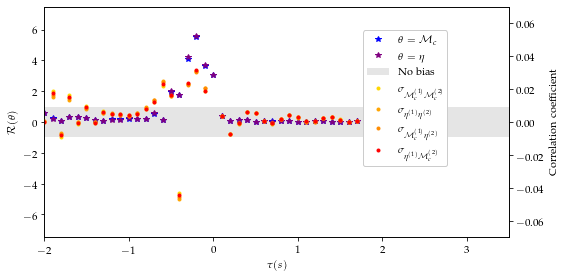

In [31]:
fig, ax1 = plt.subplots(figsize = (8,4))

ax1.set_xlabel(r'$\tau (s)$')
ax1.set_ylabel(r'$\mathcal{R}(\theta)$', color='black')
ax1.plot(tau_list, R_Mc_list,'*', color='blue',label=r'$\theta=\mathcal{M}_c$')
ax1.plot(tau_list, R_eta_list,'*', color='purple',label=r'$\theta=\eta$')
ax1.axhspan(1, -1, facecolor='gray', alpha=0.2,label='No bias')
ax1.tick_params(axis='y')
ax1.set_ylim(-7.5,7.5)
ax1.set_xlim(-2,3.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Correlation coefficient', color= 'black')  # we already handled the x-label with ax1
ax2.plot(tau_list, sigma_Mc1_Mc2_list,'.', color= 'gold',
        label=r'$\sigma_{\mathcal{M}_{c}^{(1)}\mathcal{M}_{c}^{(2)}}$')
ax2.plot(tau_list, sigma_eta1_eta2_list,'.', color= 'orange',
        label=r'$\sigma_{\eta^{(1)}\eta^{(2)}}$')
ax2.plot(tau_list, sigma_Mc1_eta2_list,'.', color= 'darkorange',
        label=r'$\sigma_{\mathcal{M}_{c}^{(1)}\eta^{(2)}}$')
ax2.plot(tau_list, sigma_Mc2_eta1_list,'.', color= 'red',
        label=r'$\sigma_{\eta^{(1)}\mathcal{M}_{c}^{(2)}}$')
ax2.tick_params(axis='y')
ax2.set_ylim(-0.07,0.07)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
legend=fig.legend(bbox_to_anchor=(.63,.86), 
           loc='upper left', borderaxespad=0.)
legend.get_frame().set_alpha(None)
#plt.savefig('R_theta_and_correlations.pdf')
plt.tight_layout()
plt.show()

Do we trust the Fisher matrix? 

Notice that the most problematic case is that for which $\tau = -0.2$. This was our choice in the MCMC calculation, and we just checked that the MCMC agrees with the Fisher matrix!

Therefore we can be sure the plot above is sensible.

In [32]:
# Tau corresponding to the largest bias.
# Indeed it is the time of coalescence used in the MCMC!

index_max = np.where(R_Mc_list==max(R_Mc_list))[0][0]
tau_list[index_max]

-0.2